# Tutorial 2 : Neural Processes - 1D GP Data

Last Update : 27 August 2019

**Aim**: 
- Training a simple [Neural Process]
- See how well a NP "learns" a GP kernel

**Nota Bene:**
- Much more details about the framework and dataset can be found in [Tutorial 1 - Conditional Neural Process].
- Not much hyperparameter optimization done
- Architecture differs slightly from the paper to be more general and modularizable for future work.


[Neural Process]: https://arxiv.org/abs/1807.01622
[Conditional Neural Process]: https://arxiv.org/pdf/1807.01613.pdf
[Attentive Neural Process]: https://arxiv.org/abs/1901.05761
[Image Transformer]: https://arxiv.org/abs/1802.05751
[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb
[Tutorial 2 - Neural Process]: Tutorial%202%20-%20Neural%20Process.ipynb
[Tutorial 3 - Attentive Neural Process]: Tutorial%203%20-%20Attentive%20Neural%20Process.ipynb

**Environment Hypermarameters:**

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/private/home/yannd/projects/NPF


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

The dataset we will be using are simple functions sampled from different Gaussian kernel. See [Tutorial 1 - Conditional Neural Process] for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [4]:
from utils.visualize import plot_dataset_samples_1d, plot_prior_samples_1d, plot_posterior_samples_1d, plot_losses
from ntbks_helpers import get_gp_datasets_varying # defined in first tutorial (CNP)

X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 50000 

datasets, test_datasets = get_gp_datasets_varying(n_samples=N_SAMPLES, n_points=N_POINTS)

## Model

The general model architecture is slightly different from the paper to make it modular and easy to extend. Refer to [Tutorial 1 - Conditional Neural Process] for an overview main parameters or the docstrings of `NeuralProcess` for important parameters. 

Main difference with [Tutorial 1 - Conditional Neural Process]:
- `encoded_path="latent"`

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [5]:
from functools import partial
from neuralproc import LNP
from ntbks_helpers import CNP_KWARGS # defined in first tutorial (CNP)
from neuralproc.utils.helpers import LightTailPareto

np_kwargs = CNP_KWARGS.copy()
np_kwargs["encoded_path"] = "latent" # use NP
#np_kwargs["n_z_samples_train"] = 1
#np_kwargs["n_z_samples_test"] = 1
np_kwargs["is_q_zCct"] = True

model = partial(LNP, X_DIM, Y_DIM, **np_kwargs)

### N Param

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [6]:
from utils.helpers import count_parameters
print("N Param:", count_parameters(model()))

N Param: 186434


/private/home/yannd/projects/NPF/neuralproc/architectures/mlp.py:67: UserWarning: hidden_size=32 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


More parameters than CNP because need a MLP that maps $R \to Z$

# Training

The training procedure is the same as in [Tutorial 1 - Conditional Neural Process], refer to it for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [7]:
from neuralproc import ELBOLossLNPF
from utils.train import train_models
from utils.data.dataloader import cntxt_trgt_collate
from ntbks_helpers import get_cntxt_trgt

trainers = train_models(
     datasets, 
     {"LNP":model},
     ELBOLossLNPF,
    test_datasets=test_datasets,
     chckpnt_dirname="results/notebooks/neural_process/", 
     is_retrain=False, # load pretrained
     iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt), 
     iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt),
     patience=10,
    max_epochs=20,
    device="cpu",
     seed=123) 


--- Loading RBF_Kernel/LNP/run_0 ---

RBF_Kernel/LNP/run_0 | best epoch: 3 | train loss: 152.7545 | valid loss: 165.9447 | test log likelihood: -144.3268

--- Loading Periodic_Kernel/LNP/run_0 ---

Periodic_Kernel/LNP/run_0 | best epoch: 4 | train loss: 168.6796 | valid loss: 171.6887 | test log likelihood: -172.8636

--- Loading Matern_Kernel/LNP/run_0 ---

Matern_Kernel/LNP/run_0 | best epoch: 17 | train loss: 163.8819 | valid loss: 159.1201 | test log likelihood: -148.7365

--- Loading Noisy_Matern_Kernel/LNP/run_0 ---

Noisy_Matern_Kernel/LNP/run_0 | best epoch: 20 | train loss: 195.3896 | valid loss: 193.3984 | test log likelihood: -168.2321


In [ ]:
n_trainers = len(trainers)
fig, axes = plt.subplots(n_trainers, 1, figsize=(11, 5*n_trainers), sharex=True, sharey=True)
if n_trainers==1: axes = [axes]
for i, (k, trainer) in enumerate(trainers.items()):
    plot_losses(trainer.history, 
                title="Losses for {}".format(" ".join(k.split("/")).replace("_", " ")), 
                ax=axes[i])
    axes[i].set_ylim([-1, 500])
    axes[i].set_xlim([0, 100])

Note: the losses are not directly comparable to the first notebook as there also is the ELBO loss. Should run test only with NLL.

# Inference

In [9]:
INTERPOLATION_RANGE = list(datasets.values())[0].min_max

## Posterior

In [10]:
from neuralproc.utils.datasplit import CntxtTrgtGetter, GetRandomIndcs, get_all_indcs

def get_n_cntxt(n_cntxt):
    return CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=n_cntxt, max_n_indcs=n_cntxt),
                         targets_getter=get_all_indcs,
                         is_add_cntxts_to_trgts=False)

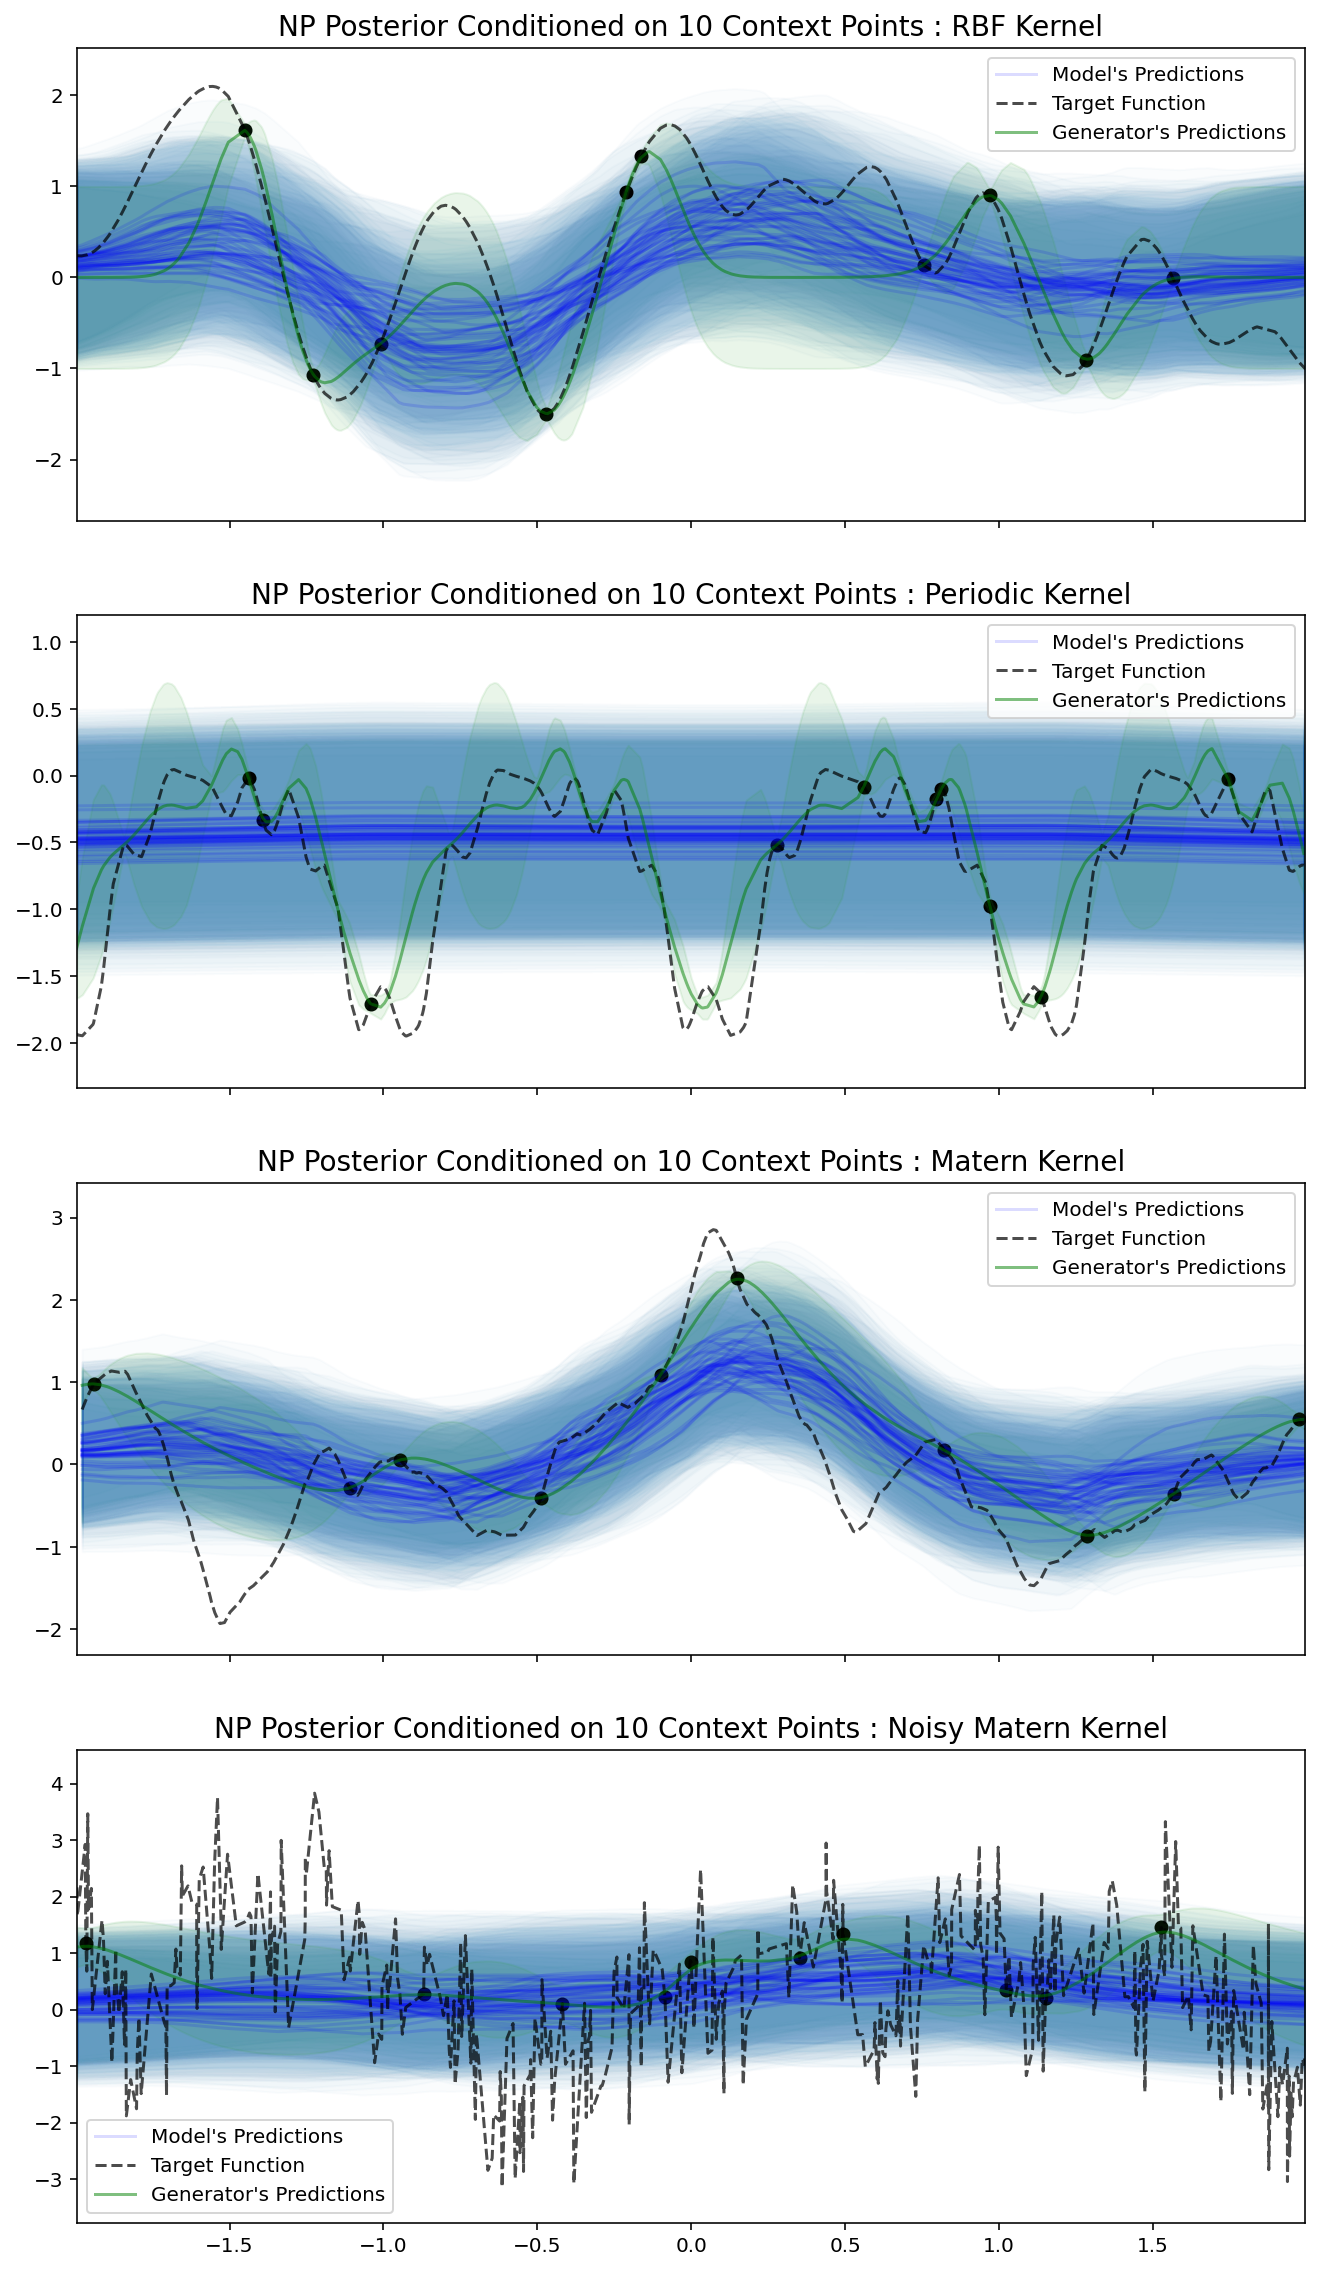

In [13]:
N_CNTXT = 10
fig, axes = plt.subplots(n_trainers, 1, figsize=(11, 5*n_trainers), sharex=True)
if n_trainers==1: axes = [axes]
    
for i, (k, trainer) in enumerate(trainers.items()):
    data_name = k.split("/")[0]
    dataset = datasets[data_name]
    
    X, Y = dataset.get_samples(n_samples=1, 
                               n_points=3*N_POINTS) # use higher density for plotting 
        
    plot_posterior_samples_1d(X, Y, get_n_cntxt(N_CNTXT), trainer.module_, 
                             generator=dataset.generator,
                             n_samples=50,
                             train_min_max=dataset.min_max,
                             is_plot_std=True,
                             title="NP Posterior Conditioned on {} Context Points : {}".format(N_CNTXT, data_name.replace("_", " ")),
                             ax=axes[i])
    

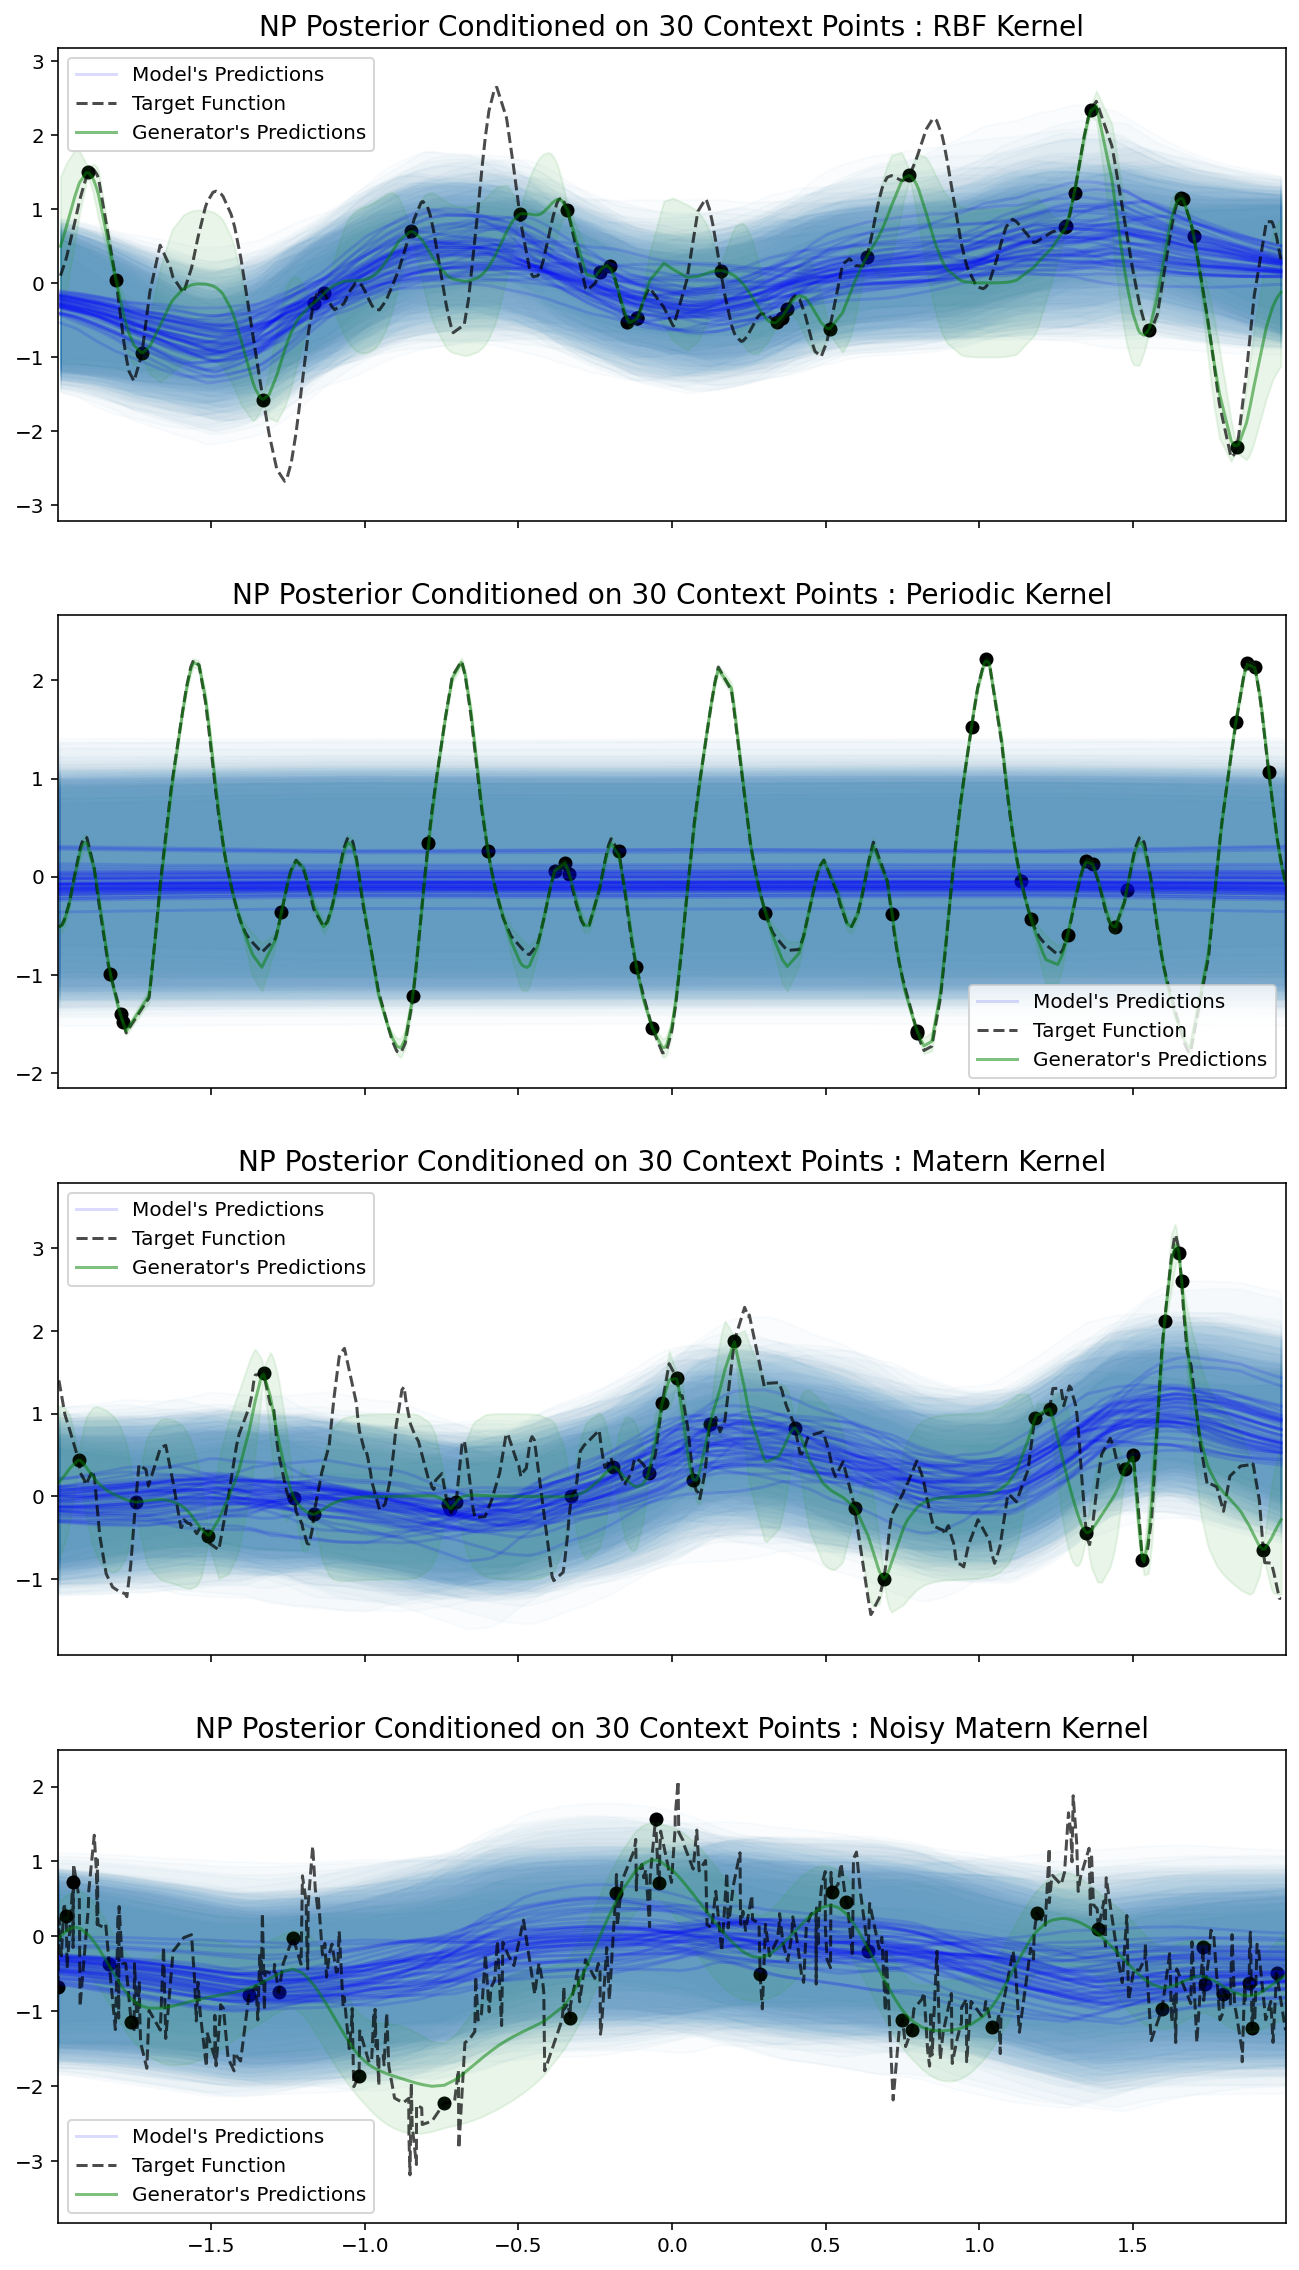

In [14]:
N_CNTXT = 30
fig, axes = plt.subplots(n_trainers, 1, figsize=(11, 5*n_trainers), sharex=True)
if n_trainers==1: axes = [axes]
    
for i, (k, trainer) in enumerate(trainers.items()):
    data_name = k.split("/")[0]
    dataset = datasets[data_name]
    
    X, Y = dataset.get_samples(n_samples=1, 
                               n_points=3*N_POINTS) # use higher density for plotting 
        
    plot_posterior_samples_1d(X, Y, get_n_cntxt(N_CNTXT), trainer.module_, 
                             generator=dataset.generator,
                             n_samples=50,
                             train_min_max=dataset.min_max,
                             is_plot_std=True,
                             title="NP Posterior Conditioned on {} Context Points : {}".format(N_CNTXT, data_name.replace("_", " ")),
                             ax=axes[i])
    

We see that the predictions are not great.


**Bad**:
- samples seem to mostly be shifted versions of the mean sample
- the predictions don't seem better with more context points
- badly underfits